In [ ]:
#라이브러리 및 드라이브 연결
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data.dataloader import Dataset, DataLoader
from google.colab import drive
drive.mount('/content/drive')
import os
import glob
import cv2
from google.colab.patches import cv2_imshow
import math
import numpy as np
import random
import matplotlib.pyplot as plt

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#파라미터 선언
n1, n2 = 64, 32
f1, f2, f3 = 9, 1, 5
upscale_factor = 3

# 패딩 없이 연산 수행시(컨볼루션 연산), 가장자리 픽셀 정보 손실. 그래서 패딩 적용 없이 출력 이미지 크기를 입력보다 작게 생성

input_size = 33
output_size = input_size - f1 - f2 - f3 + 3
stride = 14
batch_size = 16
epochs = 500
path = "/content/drive/MyDrive/Colab Notebooks/T91"
save_path = "/content/drive/MyDrive/Colab Notebooks/SCALE3_SRCNN(RGB)_500EPOCHS"

#Device 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device
print(f"Using device: {device}")
print(f"GPU 사용 가능 여부: {torch.cuda.is_available()}")
print(f"사용 중인 장치: {torch.cuda.get_device_name(0)}")


Using device: cuda
GPU 사용 가능 여부: True
사용 중인 장치: Tesla T4


In [ ]:
#저해상도와 고해상도 이미지 패치 사이의 관계 학습
#학습데이터 만들려면 1)HR->LR로 만드는 작업 과 2) 각 이미지 crop하여 mapping하는 작업 필요
class CustomDataset(Dataset):
    def __init__(self, img_paths, input_size, output_size, stride=14, upscale_factor=3):
        super(CustomDataset, self).__init__()
        self.img_paths = glob.glob(img_paths + '/' + '*.png')
        print(f"Loaded {len(self.img_paths)} images from path: {img_paths}")
        self.stride = stride
        self.upscale_factor = upscale_factor
        self.sub_lr_imgs = []
        self.sub_hr_imgs = []
        self.input_size = input_size
        self.output_size = output_size
        self.pad = (self.input_size - self.output_size)//2
        #입력 데이터(LR)와 이에 대응되는 정답 데이터(HR)를 비교하여 손실(loss)를 계산해야하는데, 그러기위해선 둘의 크기가 동일해야한다
        #그래서 self.pad를 통해 학습 데이터셋 조정.

        #이미지 데이터 전처리
        for img_path in self.img_paths:
            img = cv2.imread(img_path, cv2.IMREAD_COLOR)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)       # BGR -> RGB 변환

            # 고해상도 이미지 크기 조정: 이미지의 h, w 를 upscale_factor의 배수로 만들기 위해 단순 crop 방식(mod_crop) 사용
            h = img.shape[0] - (img.shape[0] % self.upscale_factor)
            w = img.shape[1] - (img.shape[1] % self.upscale_factor)
            img = img[:h, :w, :]

            # zoom_img(LR 이미지 생성)
            label = img.astype(np.float32) / 255.0
            temp_input = cv2.resize(label, dsize=(0, 0), fx=1/self.upscale_factor, fy=1/self.upscale_factor,
                         interpolation=cv2.INTER_AREA)
            input = cv2.resize(temp_input, dsize=(0, 0), fx=self.upscale_factor, fy=self.upscale_factor,
                    interpolation=cv2.INTER_CUBIC)

            # 그대로 RGB float32 [0,1] 상태의 배열을 사용
            input_rgb = input
            label_rgb = label

            # 7) sub-patch 크롭(RGB 패치 추출)
            #    (0, input.shape[0]-input_size+1, stride)로 슬라이딩
            for hh in range(0, input_rgb.shape[0] - self.input_size + 1, self.stride):
                for ww in range(0, input_rgb.shape[1] - self.input_size + 1, self.stride):
                    # LR 패치
                    sub_lr_img = input_rgb[hh:hh + self.input_size, ww:ww + self.input_size]
                    # HR 패치!
                    sub_hr_img = label_rgb[hh + self.pad : hh + self.pad + self.output_size, ww + self.pad : ww + self.pad + self.output_size]

                    # (H, W, C) → (C, H, W)
                    sub_lr_img = np.transpose(sub_lr_img, (2, 0, 1))  # shape: (3, input_size, input_size)
                    sub_hr_img = np.transpose(sub_hr_img, (2, 0, 1))  # shape: (3, output_size, output_size)

                    self.sub_lr_imgs.append(sub_lr_img)
                    self.sub_hr_imgs.append(sub_hr_img)

        # 리스트 → ndarray (모두 shape 통일 후)
        self.sub_lr_imgs = np.stack(self.sub_lr_imgs).astype(np.float32)  # (N,3,in,in)
        self.sub_hr_imgs = np.stack(self.sub_hr_imgs).astype(np.float32)  # (N,3,out,out)

    #PyTorch의 데이터셋 클래스(torch.utils.data.Dataset)를 상속받아 사용자 정의 데이터셋을 구현
    def __len__(self): #데이터셋의 전체 샘플 개수를 반환 -> DataLoader가 몇 개의 배치를 생성해야 할지 결정
        return len(self.sub_lr_imgs)
    def __getitem__(self, idx):   #데이터셋에서 특정 인덱스(idx)에 해당하는 데이터 샘플을 반환-->미니배치(batch) 데이터를 만든다.
        lr_img = self.sub_lr_imgs[idx]
        hr_img = self.sub_hr_imgs[idx]
        return lr_img, hr_img

In [ ]:
# 데이터셋 생성
train_dataset = CustomDataset(img_paths=path, input_size=input_size, output_size=output_size, stride=stride, upscale_factor=upscale_factor)
# DataLoader 생성
train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

# 데이터셋 크기 확인
print(f"Dataset size: {len(train_dataset)}")
print(f"Batch size: {train_dataloader.batch_size}")
print(f"Number of batches in dataloader: {len(train_dataloader)}")

Loaded 91 images from path: /content/drive/MyDrive/Colab Notebooks/T91
Dataset size: 21884
Batch size: 16
Number of batches in dataloader: 1368


In [ ]:
#test dataset 설정 part
from PIL import Image
import torchvision.transforms as transforms

class TestImageDataset(Dataset):
    def __init__(self, img_dir, upscale_factor=3, transform=None):
        """
        img_dir: 테스트 이미지들이 들어 있는 폴더 경로
        upscale_factor: SR 모델의 업스케일 배율

        """
        self.img_dir = img_dir
        self.upscale_factor = upscale_factor
        self.img_paths = sorted(glob.glob(os.path.join(img_dir, "*.png")))
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        # 1) 이미지 경로
        img_path = self.img_paths[idx]
        # 2) 이미지 로드 → RGB 전체 NumPy로 변환
        hr_pil = Image.open(img_path).convert("RGB")
        w, h = hr_pil.size
        w0, h0 = w - (w % self.upscale_factor), h - (h % self.upscale_factor)
        hr_pil = hr_pil.crop((0, 0, w0, h0))
        hr_arr = np.array(hr_pil).astype(np.float32) / 255.0  # (H, W, 3)

        lr_pil = hr_pil.resize((w0//self.upscale_factor, h0//self.upscale_factor),resample=Image.BICUBIC)
        lr_pil = lr_pil.resize((w0, h0), resample=Image.BICUBIC)
        lr_arr = np.array(lr_pil).astype(np.float32) / 255.0  # (H, W, 3)

        # 5) (H, W, C) → (C, H, W) & Tensor 변환
        hr_img = torch.from_numpy(hr_arr.transpose(2, 0, 1))  # Tensor (3,H,W)
        lr_img = torch.from_numpy(lr_arr.transpose(2, 0, 1))  # Tensor (3,H,W)
        if self.transform:
          hr_img = self.transform(hr_img)
          lr_img = self.transform(lr_img)
        return hr_img, lr_img


# ------------------------------------------------
# 테스트 데이터셋/로더 생성
# ------------------------------------------------
hr_img_path = "/content/drive/MyDrive/Colab Notebooks/Set 5"

test_dataset = TestImageDataset(hr_img_path,upscale_factor=3, transform=None)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# ------------------------------------------------
# 데이터셋 크기 확인
# ------------------------------------------------
print(f"테스트 이미지 개수: {len(test_dataset)}")

# ------------------------------------------------
# 배치 순회 예시
# ------------------------------------------------
for i, (hr_img, lr_img) in enumerate(test_dataloader, start=1):
    print(f"[Batch {i}] HR Y 텐서 크기: {hr_img.shape}, LR Y 텐서 크기: {lr_img.shape}")
    # 필요 시 break로 일부만 확인
    if i >= 5:
        break

테스트 이미지 개수: 5
[Batch 1] HR Y 텐서 크기: torch.Size([1, 3, 510, 510]), LR Y 텐서 크기: torch.Size([1, 3, 510, 510])
[Batch 2] HR Y 텐서 크기: torch.Size([1, 3, 288, 288]), LR Y 텐서 크기: torch.Size([1, 3, 288, 288])
[Batch 3] HR Y 텐서 크기: torch.Size([1, 3, 255, 255]), LR Y 텐서 크기: torch.Size([1, 3, 255, 255])
[Batch 4] HR Y 텐서 크기: torch.Size([1, 3, 279, 279]), LR Y 텐서 크기: torch.Size([1, 3, 279, 279])
[Batch 5] HR Y 텐서 크기: torch.Size([1, 3, 342, 228]), LR Y 텐서 크기: torch.Size([1, 3, 342, 228])


Original image shape (BGR): (151, 136, 3)
Mod cropped image shape (RGB): (150, 135, 3)


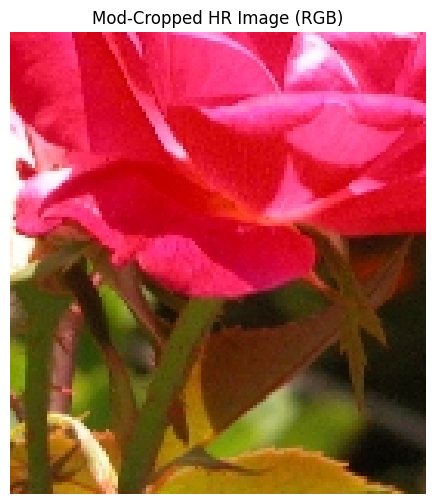

In [ ]:
# 원본 HR이미지 확인
img_path = train_dataset.img_paths[47]
img = cv2.imread(img_path, cv2.IMREAD_COLOR)
print("Original image shape (BGR):", img.shape)

# BGR → RGB 변환
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Upscale factor에 맞게 mod crop 수행
upscale_factor = 3
h, w, _ = img.shape
h_mod = h - (h % upscale_factor)
w_mod = w - (w % upscale_factor)
img_cropped = img_rgb[:h_mod, :w_mod, :]
print("Mod cropped image shape (RGB):", img_cropped.shape)

# 4) RGB 컬러 영상 표시
plt.figure(figsize=(6, 6))
plt.imshow(img_cropped)
plt.title("Mod-Cropped HR Image (RGB)")
plt.axis("off")
plt.show()


전체 인덱스 범위: 0 ~ 21883
index number: 10101


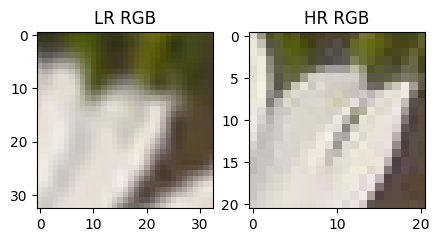

In [ ]:
# (저해상도, 고해상도) Paired 이미지 패치 확인 (RGB 컬러)
if len(train_dataset.sub_lr_imgs) > 0:  # 데이터 존재 여부 확인
    fig, axes = plt.subplots(1, 2, figsize=(5, 5))
    idx = random.randint(0, len(train_dataset.sub_lr_imgs) - 1)
    num_samples = len(train_dataset.sub_lr_imgs)
    print(f"전체 인덱스 범위: 0 ~ {num_samples - 1}")

    # RGB 패치 (3,H,W) → (H,W,3) 로 변환
    lr_img = np.transpose(train_dataset.sub_lr_imgs[idx], (1, 2, 0))  # (H, W, 3)
    hr_img = np.transpose(train_dataset.sub_hr_imgs[idx], (1, 2, 0))  # (H, W, 3)

    axes[0].imshow(lr_img)
    axes[1].imshow(hr_img)
    axes[0].set_title('LR RGB')
    axes[1].set_title('HR RGB')

    print("index number:", idx)
    plt.show()
else:
    print("No images available for visualization!")

In [ ]:
# Model 선언
class SRCNN(nn.Module):
    def __init__(self, kernel_list, filters_list, num_channels=3):
        super(SRCNN, self).__init__()

        f1, f2, f3 = kernel_list
        n1, n2 = filters_list

        # 모델 계층 정의
        self.conv1 = nn.Conv2d(num_channels, n1, kernel_size=f1, padding=0)
        self.conv2 = nn.Conv2d(n1, n2, kernel_size=f2, padding=0)
        self.conv3 = nn.Conv2d(n2, num_channels, kernel_size=f3, padding=0)
        self.relu = nn.ReLU(inplace=True)

        # 모든 nn.Conv2d 모듈을 순회하여 He 초기화 방식(변형)을 적용.
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
              # He 초기화 (Kaiming normal)
              nn.init.kaiming_normal_(
                  m.weight,
                  mode='fan_in',
                  nonlinearity='relu'
              )
              if m.bias is not None:
                nn.init.zeros_(m.bias)

        print(f"Conv3 output channels: {self.conv3.out_channels}")

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)
        x = torch.clamp(x, 0.0, 1.0)
        return x


In [ ]:
def get_psnr(label, output, boundary=0, max_value=1.0):
    """
    PSNR (Peak Signal-to-Noise Ratio) 계산 함수 (RGB 컬러 영상 전 채널 기준)

    Args:
        label   (Tensor or np.ndarray): 정답 이미지, shape=(C,H,W), 값 범위 [0,1]
        output  (Tensor or np.ndarray): 예측 이미지, same shape as label
        boundary (int): 테두리 잘라낼 픽셀 수 (기본 0)
        max_value (float): 최대 픽셀 값 (0~1 스케일일 때 1.0)

    Returns:
        float: PSNR (dB)
    """
    # — 1) boundary 크롭 (원본 코드와 동일) —
    if boundary > 0:
        if isinstance(label, torch.Tensor):
            label  = label[..., boundary:-boundary, boundary:-boundary]
            output = output[..., boundary:-boundary, boundary:-boundary]
        else:
            label  = label[..., boundary:-boundary, boundary:-boundary]
            output = output[..., boundary:-boundary, boundary:-boundary]

    # shape 검증
    assert label.shape == output.shape, "Input images must have the same dimensions."

    # — 2) MSE 계산 (RGB 3채널 전체) —
    if isinstance(label, torch.Tensor):
        mse = torch.mean((label - torch.clamp(output, 0.0, max_value)) ** 2)
        psnr = 10 * torch.log10((max_value ** 2) / (mse + 1e-10))
        return psnr.item()
    else:
        mse = np.mean((label - output) ** 2)
        return 10 * np.log10((max_value ** 2) / (mse + 1e-10))


In [ ]:
# Train & Test loop
def train(dataloader, model, loss_fn, optimizer,device,epochs):
  global train_losses, train_psnrs  # 전역 변수로 설정 ,저장할 리스트도 추가
  model.train()
  running_loss = 0.0
  running_psnr = 0.0
  num_batches = len(dataloader)

  for batch_idx, (X, y) in enumerate(dataloader,start=1):
    #dataloader는 데이터를 미니배치로 분리하여 제공
    #데이터이동
    X = X.to(device)
    y = y.to(device)

    #예측 및 손실 계산
    pred = model(X)
    # 2) valid 영역 크기(pad) 계산 & 중앙 크롭 타깃
    pad = (y.size(-1) - pred.size(-1)) // 2        # =6
    if pad > 0:
      y_crop = y[..., pad:-pad, pad:-pad]        # [B,1,21,21]
    else:
      y_crop = y                                 # (패딩 없을 땐 full)

    # 3) 손실 계산 (predict vs cropped target)
    loss = loss_fn(pred, y_crop)

    #역전파
    optimizer.zero_grad() #이전 미니배치에서 계산된 기울기(gradients)를 초기화
    loss.backward() #손실 값에 대해 모델의 각 파라미터(가중치, 편향)의 기울기를 계산
    optimizer.step() #계산된 기울기를 사용하여 모델의 파라미터를 업데이트

    # PSNR 계산 (같은 y_crop 사용)
    with torch.no_grad():
            pred_clamped = torch.clamp(pred, 0.0, 1.0)
            mse = torch.mean((y_crop - pred_clamped) ** 2)
            psnr_value = 10.0 * torch.log10(1.0 / (mse + 1e-10))

    running_loss += loss.item()  # 손실 누적
    running_psnr += psnr_value.item()  # PSNR 값 누적

  # Epoch별 평균
  avg_loss = running_loss / num_batches
  avg_psnr = running_psnr / num_batches
  train_losses.append(avg_loss)
  train_psnrs.append(avg_psnr)
  print(f"Epoch Completed: Loss = {avg_loss:.6f} | PSNR = {avg_psnr} dB")
  return avg_loss, avg_psnr  #손실과 PSNR 반환

In [ ]:
# Model 선언
model = SRCNN(kernel_list=[f1, f2, f3],
              filters_list=[n1, n2],
              num_channels=3).to(device)
print(model)

# 손실 함수
loss_fn = nn.MSELoss()

# 논문 기반 학습률 설정/ Conv1, Conv2 레이어: 1e-4, Conv3 레이어: 1e-5
optimizer = optim.Adam(
    [
        {'params': model.conv1.parameters(), 'lr': 1e-4},
        {'params': model.conv2.parameters(), 'lr': 1e-4},
        {'params': model.conv3.parameters(), 'lr': 1e-5},
    ],

)


Conv3 output channels: 3
SRCNN(
  (conv1): Conv2d(3, 64, kernel_size=(9, 9), stride=(1, 1))
  (conv2): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
  (conv3): Conv2d(32, 3, kernel_size=(5, 5), stride=(1, 1))
  (relu): ReLU(inplace=True)
)


In [ ]:
# Model Training
train_losses = []
train_psnrs = []

for i in range(epochs):
  print(f"Epoch {i + 1} of {epochs}")
  model.train()
  if train_dataloader is None:
      raise ValueError("train_dataloader가 None입니다. 데이터 로더를 확인하세요.")

  train_loss, train_psnr = train(train_dataloader, model, loss_fn, optimizer,device,epochs)

print("Done!")
torch.save(model.state_dict(), save_path)

Epoch 1 of 500
Epoch Completed: Loss = 0.039316 | PSNR = 18.407602134852382 dB
Epoch 2 of 500
Epoch Completed: Loss = 0.003111 | PSNR = 25.2975653458757 dB
Epoch 3 of 500
Epoch Completed: Loss = 0.002612 | PSNR = 26.069566033737004 dB
Epoch 4 of 500
Epoch Completed: Loss = 0.002413 | PSNR = 26.43968865745946 dB
Epoch 5 of 500
Epoch Completed: Loss = 0.002317 | PSNR = 26.61196978189792 dB
Epoch 6 of 500
Epoch Completed: Loss = 0.002259 | PSNR = 26.732896673749064 dB
Epoch 7 of 500
Epoch Completed: Loss = 0.002223 | PSNR = 26.801058530807495 dB
Epoch 8 of 500
Epoch Completed: Loss = 0.002196 | PSNR = 26.883342787536264 dB
Epoch 9 of 500
Epoch Completed: Loss = 0.002174 | PSNR = 26.92183068342376 dB
Epoch 10 of 500
Epoch Completed: Loss = 0.002157 | PSNR = 26.943931419249864 dB
Epoch 11 of 500
Epoch Completed: Loss = 0.002143 | PSNR = 26.963990967176112 dB
Epoch 12 of 500
Epoch Completed: Loss = 0.002128 | PSNR = 27.031285358451264 dB
Epoch 13 of 500
Epoch Completed: Loss = 0.002117 | PSN

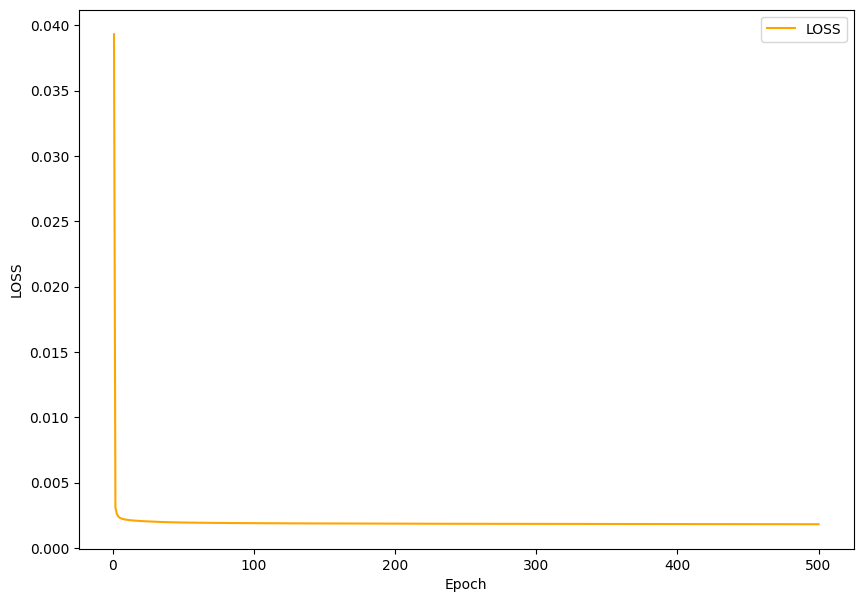

In [ ]:
# loss plots
if not train_losses:
    print("Error: train_losses empty")

plt.figure(figsize=(10, 7))
plt.plot(range(1, len(train_losses)+1), train_losses, color='orange', label='LOSS')
plt.xlabel('Epoch')
plt.ylabel('LOSS')
plt.legend()
plt.show()

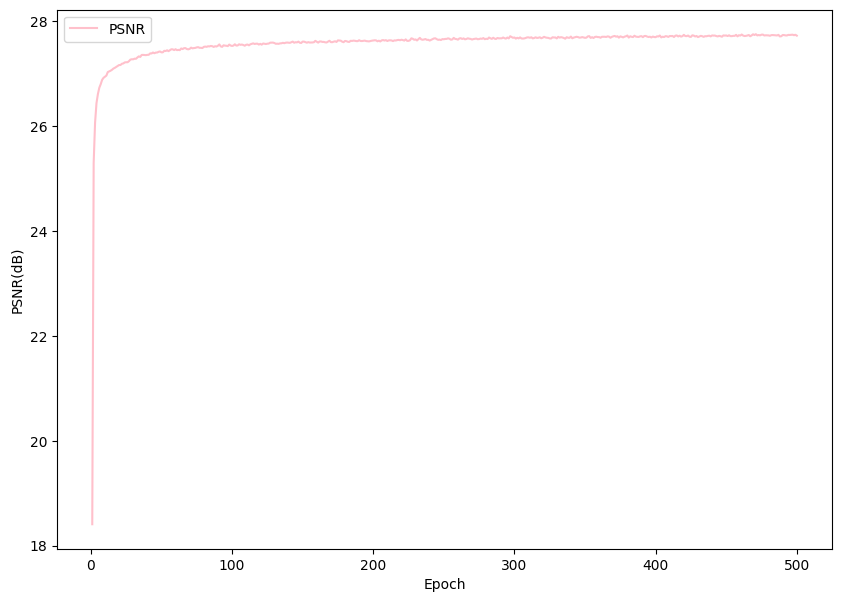

In [ ]:
# PSNR plots
if not train_psnrs:
    print("Error: train_psnrs empty")

plt.figure(figsize=(10, 7))
plt.plot(range(1, len(train_psnrs)+1), train_psnrs, color='pink', label='PSNR')
plt.xlabel('Epoch')
plt.ylabel('PSNR(dB)')
plt.legend()
plt.show()

Image butterfly.png loaded successfully: (256, 256, 3)


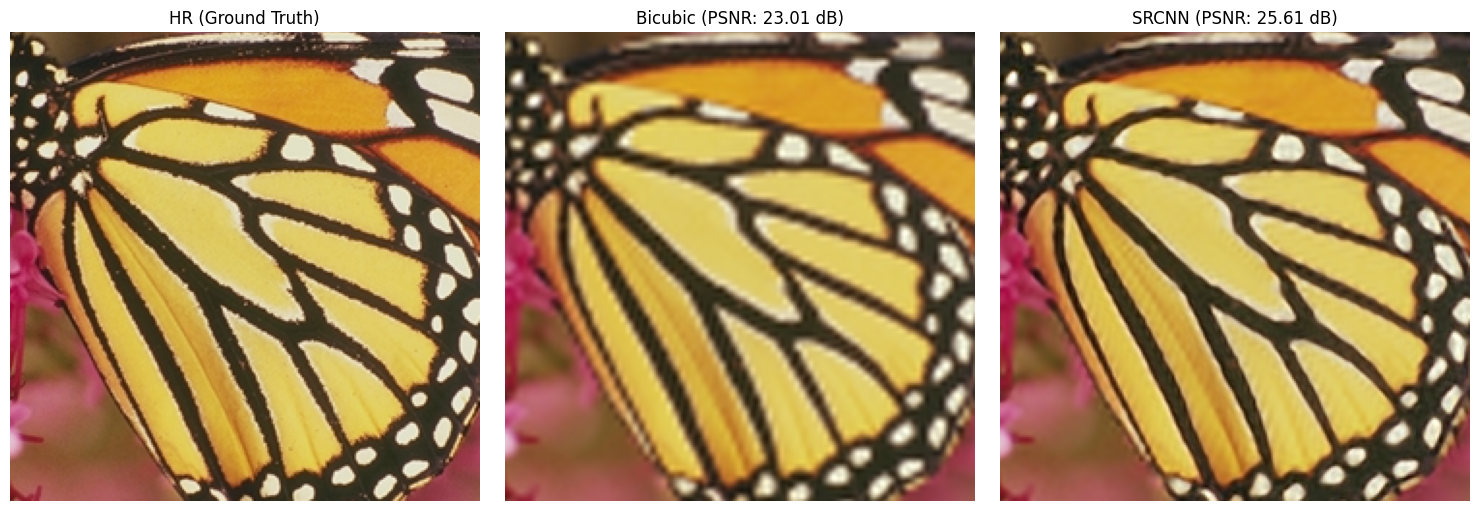

HR RGB range:      min=0.000, max=0.988, dtype=float32
Bicubic RGB range: min=0.010, max=1.000, dtype=float32
SRCNN RGB range:   min=0.000, max=1.000, dtype=float32


In [ ]:
import os
import cv2
import glob
import random
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F

# --- 1. 이미지 변환 관련 함수들 ---
upscale_factor=3
# PSNR 계산 함수
def calculate_psnr(img1, img2, max_val=1.0):
    mse = np.mean((img1 - img2) ** 2)
    psnr = 10 * np.log10((max_val ** 2) / (mse + 1e-10))
    return psnr

# 중앙 crop 함수
def center_crop(img, height, width):
    h, w = img.shape[:2]
    start_h = (h - height) // 2
    start_w = (w - width) // 2
    if img.ndim == 3:
        return img[start_h:start_h + height, start_w:start_w + width, :]
    else:
        return img[start_h:start_h + height, start_w:start_w + width]


# --- 2. 테스트 이미지 로드 및 전처리 ---

hr_img_path = '/content/drive/MyDrive/Colab Notebooks/Set 5'

if not os.path.exists(hr_img_path):
    print(f"Error: Folder not found at {hr_img_path}")
    exit()

# 디렉토리 내 모든 이미지 파일 가져오기
img_files = [f for f in os.listdir(hr_img_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
if len(img_files) == 0:
    print("Error: No image files found in the directory.")
    exit()

# 랜덤으로 하나의 이미지 선택
img_file = random.choice(img_files)
img_path = os.path.join(hr_img_path, img_file)
hr_img = cv2.imread(img_path, cv2.IMREAD_COLOR)
if hr_img is None:
    print(f"Error: Image {img_file} cannot be read. Check the file format.")
    exit()

# BGR -> RGB 변환
hr_img = cv2.cvtColor(hr_img, cv2.COLOR_BGR2RGB)
print(f"Image {img_file} loaded successfully: {hr_img.shape}")

# 정규화 및 float32 변환 (0~1)
hr_img = hr_img.astype(np.float32) / 255.0

# 고해상도 이미지 크기 조정:  단순 crop (mod_crop) 사용
h, w, _ = hr_img.shape
h_new = h - (h % upscale_factor)
w_new = w - (w % upscale_factor)
hr_img_cropped = hr_img[:h_new, :w_new, :]
# --- 3. Bicubic 보간법으로 LR 이미지 생성 및 Bicubic 이미지를 RGB 컬러로 그대로 사용 ---

# LR 이미지 생성: 다운샘플( INTER_AREA ) 후 업샘플( INTER_CUBIC )
temp_img = cv2.resize(hr_img_cropped, dsize=(0, 0), fx=1/upscale_factor, fy=1/upscale_factor, interpolation=cv2.INTER_AREA)
bicubic_img = cv2.resize(temp_img, dsize=(0, 0), fx=upscale_factor, fy=upscale_factor, interpolation=cv2.INTER_CUBIC)
bicubic_img = np.clip(bicubic_img, 0.0, 1.0)

# HR 및 Bicubic 이미지
hr_rgb      = hr_img_cropped
bicubic_rgb = bicubic_img

# --- 4. SRCNN 모델 추론을 통한 결과 생성 ---

# 모델 입력 준비: Bicubic RGB 컬러 사용
# (H, W, 3) -> (3, H, W) -> (1, 3, H, W)
input_arr    = bicubic_rgb.transpose(2, 0, 1)[None, ...]      # (1, 3, H, W)
input_tensor = torch.from_numpy(input_arr).to(device)

# 모델 가중치 불러오기 및 평가 모드 설정
model.load_state_dict(torch.load(save_path, map_location=device))
model.to(device)
model.eval()

with torch.no_grad():
    output_tensor = model(input_tensor)
# 모델 출력: (B, 3, H, W) -> (H, W, 3)
srcnn_rgb = output_tensor.squeeze(0).cpu().numpy().transpose(1, 2, 0)
srcnn_rgb = np.clip(srcnn_rgb, 0.0, 1.0)

# --- 5. 중앙 Crop (RGB 컬러) ---
# 모든 이미지 (hr_rgb, bicubic_rgb, srcnn_rgb)는 (H, W, 3)
min_h = min(hr_rgb.shape[0], bicubic_rgb.shape[0], srcnn_rgb.shape[0])
min_w = min(hr_rgb.shape[1], bicubic_rgb.shape[1], srcnn_rgb.shape[1])
hr_rgb_cropped      = center_crop(hr_rgb,      min_h, min_w)
bicubic_rgb_cropped = center_crop(bicubic_rgb, min_h, min_w)
srcnn_rgb_cropped   = center_crop(srcnn_rgb,   min_h, min_w)

# --- 6. PSNR 계산 ---
psnr_bicubic = calculate_psnr(hr_rgb_cropped, bicubic_rgb_cropped)
psnr_srcnn   = calculate_psnr(hr_rgb_cropped, srcnn_rgb_cropped)

# --- 7. 시각화 (RGB 컬러) ---
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(hr_rgb_cropped)
axes[0].set_title("HR (Ground Truth)")
axes[1].imshow(bicubic_rgb_cropped)
axes[1].set_title(f"Bicubic (PSNR: {psnr_bicubic:.2f} dB)")
axes[2].imshow(srcnn_rgb_cropped)
axes[2].set_title(f"SRCNN (PSNR: {psnr_srcnn:.2f} dB)")
for ax in axes:
  ax.axis("off")
plt.tight_layout()
plt.show()
# --- 8. 이미지 범위 및 dtype 확인 (RGB) ---
print(f"HR RGB range:      min={hr_rgb_cropped.min():.3f}, max={hr_rgb_cropped.max():.3f}, dtype={hr_rgb_cropped.dtype}")
print(f"Bicubic RGB range: min={bicubic_rgb_cropped.min():.3f}, max={bicubic_rgb_cropped.max():.3f}, dtype={bicubic_rgb_cropped.dtype}")
print(f"SRCNN RGB range:   min={srcnn_rgb_cropped.min():.3f}, max={srcnn_rgb_cropped.max():.3f}, dtype={srcnn_rgb_cropped.dtype}")




In [ ]:
# ------------------------------
# 4. 폴더 내 모든 Test 이미지 평균 PSNR
# ------------------------------
psnr_bicubic_list = []
psnr_srcnn_list   = []
upscale_factor    = 3

for f in img_files:
    img_path = os.path.join(hr_img_path, f)
    hr_img_all = cv2.imread(img_path, cv2.IMREAD_COLOR)
    if hr_img_all is None:
        print(f"Error reading {f}, skip.")
        continue

    # BGR → RGB, [0,1] 정규화
    hr_img_all = cv2.cvtColor(hr_img_all, cv2.COLOR_BGR2RGB)
    hr_img_all = hr_img_all.astype(np.float32) / 255.0

    # mod-crop
    hh, ww, _ = hr_img_all.shape
    hh_mod = hh - (hh % upscale_factor)
    ww_mod = ww - (ww % upscale_factor)
    hr_img_all = hr_img_all[:hh_mod, :ww_mod, :]

    # Bicubic 보간
    tmp = cv2.resize(
        hr_img_all,
        dsize=(0, 0),
        fx=1.0/upscale_factor,
        fy=1.0/upscale_factor,
        interpolation=cv2.INTER_AREA
    )
    bicubic_img_all = cv2.resize(
        tmp,
        dsize=(0, 0),
        fx=upscale_factor,
        fy=upscale_factor,
        interpolation=cv2.INTER_CUBIC
    )
    bicubic_img_all = np.clip(bicubic_img_all, 0.0, 1.0)

    # 모델 입력 준비: (H, W, 3) → (3, H, W) → (1, 3, H, W)
    inp = bicubic_img_all.transpose(2, 0, 1)[None, ...]
    input_tensor_all = torch.from_numpy(inp).to(device)

    # 추론
    with torch.no_grad():
        out_all = model(input_tensor_all)  # (1, 3, H, W)
    srcnn_rgb_all = out_all.squeeze(0).cpu().numpy().transpose(1, 2, 0)
    srcnn_rgb_all = np.clip(srcnn_rgb_all, 0.0, 1.0)

    # 중앙 크롭 (RGB)
    min_h_all = min(hr_img_all.shape[0], bicubic_img_all.shape[0], srcnn_rgb_all.shape[0])
    min_w_all = min(hr_img_all.shape[1], bicubic_img_all.shape[1], srcnn_rgb_all.shape[1])
    hr_all_c    = center_crop(hr_img_all,    min_h_all, min_w_all)
    bic_all_c   = center_crop(bicubic_img_all, min_h_all, min_w_all)
    srcnn_all_c = center_crop(srcnn_rgb_all,   min_h_all, min_w_all)

    # PSNR 계산
    psnr_bi = calculate_psnr(hr_all_c, bic_all_c)
    psnr_sr = calculate_psnr(hr_all_c, srcnn_all_c)

    # 결과 리스트에 저장
    psnr_bicubic_list.append(psnr_bi)
    psnr_srcnn_list.append(psnr_sr)

# 평균 PSNR 출력
if psnr_bicubic_list:
    avg_bicubic = sum(psnr_bicubic_list) / len(psnr_bicubic_list)
    avg_srcnn   = sum(psnr_srcnn_list)   / len(psnr_srcnn_list)
    print(f"\n[Average PSNR on Test Images]")
    print(f"Bicubic: {avg_bicubic:.2f} dB, SRCNN: {avg_srcnn:.2f} dB")
else:
    print("No valid images to compute average PSNR.")



[Average PSNR on Test Images]
Bicubic: 28.89 dB, SRCNN: 30.23 dB
